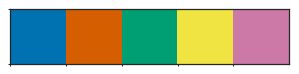

In [1]:
import re
import random
from glob import glob
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn.utils import ci

import pysam
from matplotlib_venn import venn2
from splice_simulation import (get_splice_junctions_for_query,
                               get_splice_juncs_and_sequence,
                               filter_unspliced_kmers,
                               cluster_junctions_by_seq,
                               sample_splice_junctions)
%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
acc = pd.read_csv('../exitron_splice_junction_weblogos/PRJNA323955.txt',
                  sep='\t', header=0,
                  usecols=['run_accession', 'library_name'])
acc['library_type'] = acc.library_name.str.split('_', expand=True)[0]
acc.head()

,run_accession,library_name,library_type
0,SRR3664372,APL_1,APL
1,SRR3664373,APL_2,APL
2,SRR3664374,COR_2,COR
3,SRR3664375,COR_3,COR
4,SRR3664376,E30_1,E30


In [3]:
query = ('3', 10700562, 10704018)
fasta = pysam.FastaFile(
    '/home/matthew/Documents/genomes/tair10/fasta/tair10_genome.fa')
simul_glob = ('/home/matthew/sharc_fastdata/tair10_splicing_benfey/'
              'SRR*.simulated.bam.bai')
simul_set = set([x.strip('.simulated.bam.bai') for x in glob(simul_glob)])

real_glob = ('/home/matthew/sharc_fastdata/tair10_splicing_benfey/'
             'SRR*.star.bam.bai')
real_set = set([x.strip('.star.bam.bai') for x in glob(real_glob)])
set_intersect = simul_set.intersection(real_set)
simul_bam_files = [pysam.AlignmentFile(x + '.simulated.bam', 'rb')
                  for x in set_intersect]
real_bam_files = [pysam.AlignmentFile(x + '.star.bam', 'rb')
                  for x in set_intersect]

In [6]:
simul_junction_counts = {re.search('SRR\d{7}', bam.filename.decode()).group(0):
                         get_splice_junctions_for_query(query, bam, min_overhang=20) for bam in simul_bam_files}

filt_simul_junction_counts = {k: filter_unspliced_kmers(sample, query, fasta, overhang=20)
                              for k, sample in simul_junction_counts.items()}

simul_expression = {
    re.search('SRR\d{7}', bam.filename.decode()).group(0):
    (len([aln for aln in bam.fetch(*query) if aln.reference_start > query[1] and aln.reference_end < query[2]]),
     len([aln for aln in bam.fetch(*query) if aln.reference_start > query[1] and aln.reference_end < query[2] and 'N' in aln.cigarstring]))
    for bam in simul_bam_files
}

real_junction_counts = {re.search('SRR\d{7}', bam.filename.decode()).group(0):
                        get_splice_junctions_for_query(query, bam, min_overhang=20) for bam in real_bam_files}

filt_real_junction_counts = {k: filter_unspliced_kmers(sample, query, fasta, overhang=20)
                         for k, sample in real_junction_counts.items()}
real_expression = {
    re.search('SRR\d{7}', bam.filename.decode()).group(0):
    (len([aln for aln in bam.fetch(*query) if aln.reference_start > query[1] and aln.reference_end < query[2]]),
     len([aln for aln in bam.fetch(*query) if aln.reference_start > query[1] and aln.reference_end < query[2] and 'N' in aln.cigarstring]))
    for bam in real_bam_files
}

In [7]:
real_junction_count_total = [(acc, sum(junc.values()), *real_expression[acc]) for acc, junc in filt_real_junction_counts.items()]
real_junction_count_total = pd.DataFrame.from_records(real_junction_count_total, columns=['run_accession', 'spliced_reads', 'total_expression', 'spliced_count_unfiltered'])
real_junction_count_total = real_junction_count_total.merge(acc, on='run_accession', how='left')
real_junction_count_total['percent_spliced'] = real_junction_count_total.spliced_count_unfiltered / real_junction_count_total.total_expression * 100
real_junction_count_total.head()

,run_accession,spliced_reads,total_expression,spliced_count_unfiltered,library_name,library_type,percent_spliced
0,SRR3664436,124,88722,4577,COBL9_3,COBL9,5.158811
1,SRR3664418,31,13539,793,CHX_3,CHX,5.857153
2,SRR3664387,0,382,16,S17_2,S17,4.188482
3,SRR3664433,402,144610,9489,whole_XXXXX3,whole,6.561787
4,SRR3664434,436,110381,7985,whole_XXXXX4,whole,7.234035


In [8]:
simul_junction_count_total = [(acc, sum(junc.values()), *simul_expression[acc]) for acc, junc in filt_simul_junction_counts.items()]
simul_junction_count_total = pd.DataFrame.from_records(simul_junction_count_total, columns=['run_accession', 'spliced_reads', 'total_expression', 'spliced_count_unfiltered'])
simul_junction_count_total = simul_junction_count_total.merge(acc, on='run_accession', how='left')
simul_junction_count_total['percent_spliced'] = simul_junction_count_total.spliced_count_unfiltered / simul_junction_count_total.total_expression * 100
simul_junction_count_total.head()

,run_accession,spliced_reads,total_expression,spliced_count_unfiltered,library_name,library_type,percent_spliced
0,SRR3664436,372,97285,4566,COBL9_3,COBL9,4.693427
1,SRR3664418,24,14251,571,CHX_3,CHX,4.006736
2,SRR3664387,4,469,18,S17_2,S17,3.837953
3,SRR3664433,336,159172,6540,whole_XXXXX3,whole,4.108763
4,SRR3664434,136,111392,4220,whole_XXXXX4,whole,3.788423


In [10]:
real_junction_count_total.sort_values('total_expression')

,run_accession,spliced_reads,total_expression,spliced_count_unfiltered,library_name,library_type,percent_spliced,log_total_expression
8,SRR3664406,0,26,0,CO2_2,CO2,0.000000,4.700440
20,SRR3664395,0,36,1,CO2_1,CO2,2.777778,5.169925
11,SRR3664412,0,142,6,WOX5_1,WOX5,4.225352,7.149747
23,SRR3664390,0,152,4,S18_3,S18,2.631579,7.247928
9,SRR3664413,0,162,3,WOX5_2,WOX5,1.851852,7.339850
40,SRR3664417,0,206,11,CO2_3,CO2,5.339806,7.686501
28,SRR3664396,0,212,18,S4_2,S4,8.490566,7.727920
10,SRR3664378,0,256,19,E30_3,E30,7.421875,8.000000
2,SRR3664387,0,382,16,S17_2,S17,4.188482,8.577429
45,SRR3664398,2,477,27,S4_NEW1,S4,5.660377,8.897845


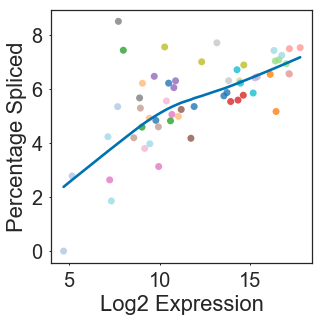

In [9]:
real_junction_count_total['log_total_expression'] = np.log2(real_junction_count_total.total_expression)
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x='log_total_expression', y='percent_spliced',
            lowess=True,
            scatter_kws={'c': real_junction_count_total.library_type.astype('category').cat.codes,
                         'color': None,
                         'cmap': 'tab20'},
            data=real_junction_count_total)
ax.set_xlabel('Log2 Expression')
ax.set_ylabel('Percentage Spliced')
plt.tight_layout()
plt.savefig('expression_vs_percent_spliced.svg')
plt.show()

In [ ]:
simul_junction_count_total['log_total_expression'] = np.log2(simul_junction_count_total.total_expression)
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x='log_total_expression', y='percent_spliced',
            lowess=True,
            scatter_kws={'c': simul_junction_count_total.library_type.astype('category').cat.codes,
                         'color': None,
                         'cmap': 'tab20'},
            data=simul_junction_count_total)
ax.set_xlabel('Log2 Expression')
ax.set_ylabel('Percentage Spliced')
plt.tight_layout()
plt.show()

In [ ]:
n_iter = 500
sample_junct_counts = {'real': defaultdict(list),
                       'simulated': defaultdict(list)}
for i in range(min([len(simul_bam_files), len(real_bam_files)])):
    for _ in range(n_iter):
        idx = random.sample(list(filt_simul_junction_counts), i)
        for counts, key in zip([filt_simul_junction_counts, filt_real_junction_counts],
                               ['simulated', 'real']):
            sample = sample_splice_junctions(counts, idx=idx)
            if sample:
                sample = cluster_junctions_by_seq(sample, query[0], fasta,
                                                  max_edit_distance=2)
            sample_junct_counts[key][i].append(len(sample))

real = pd.DataFrame(sample_junct_counts['real'])
simul = pd.DataFrame(sample_junct_counts['simulated'])

In [ ]:
fig, ax = plt.subplots(figsize=(5.5, 5))
m = simul.mean(0)
ci_l, ci_u = ci(simul.values, 67, axis=0)
ax.fill_between(simul.columns.values, ci_l, ci_u, alpha=0.2, color=pal[1])
ax.plot(m, label='Simulated', color=pal[1])
m = real.mean(0)
ci_l, ci_u = ci(real.values, 67, axis=0)
ax.fill_between(real.columns.values, ci_l, ci_u, alpha=0.2, color=pal[0])
ax.plot(m, label='Real', color=pal[0])
ax.set(xlabel='Number of Samples',
       ylabel='Number of unique spliced\ndonor/acceptor pairs')
plt.legend(loc=0)
plt.tight_layout()
plt.savefig('splice_site_simulation.svg')
plt.show()